# BAL pseudobulk analysis, pt. 4

In [1]:
import collections
import itertools
import functools
import json
import math
import os
import sys
import pathlib
import datetime

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy
import statsmodels.stats.multitest
import statsmodels.regression
import statsmodels.api

import decoupler

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/scvi_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path.insert(0, "../lib/")

In [3]:
import sc_utils

In [4]:
%config InlineBackend.figure_format = "retina"

In [5]:
DATA = pathlib.Path('../../data/31_bal-object/')

In [6]:
ds_processed = sc.read_h5ad(DATA / '03_bal-object/03_bal-object.h5ad')

In [7]:
DATA_DIR = DATA / 'pseudobulk-gsva'

In [8]:
DEG_DIR = DATA / '06_pseudobulk-v3'

In [9]:
def get_color_annotations(df, mapping):
    result = []
    for column, palette in mapping.items():
        values = df[column].unique()
        if pd.api.types.is_categorical_dtype(df[column]):
            values = df[column].cat.categories
        lut = dict(zip(values, sns.color_palette(palette, n_colors=values.size).as_hex()))
        result.append(df[column].map(lut))
    return pd.concat(result, axis=1)

In [10]:
def get_cell_type_from_slug(slug: str, ds: sc.AnnData) -> str:
    for cell_type in ds.obs.cell_type.unique():
        cell_type_slug = cell_type.replace(" ", "_").replace("/", "_")
        if slug == cell_type_slug:
            return cell_type
    raise ValueError(f"Cannot find cluster for {slug}")

In [ ]:
MODEL = 'degs-status-sex'

def load_cell_type_info(folder, data_folder):
    name = folder.name
    degs = pd.read_csv(folder / MODEL / 'degs.csv', index_col=0)
    degs_filt = pd.read_csv(folder / MODEL / 'degs-filt.csv', index_col=0)
    expr = pd.read_table(data_folder / 'data' / f'{name}.txt', index_col=0)
    gene_cells = pd.read_table(data_folder / 'data' / f'{name}-n_cells.txt', index_col=0)
    meta = pd.read_csv(folder / 'meta.csv', index_col=0)

    go_ctrl = folder / MODEL / 'go-control.csv'
    if go_ctrl.exists():
        go_ctrl = pd.read_csv(go_ctrl, index_col=0)
    else:
        go_ctrl = None

    go_ssc = folder / MODEL / 'go-ssc.csv'
    if go_ssc.exists():
        go_ssc = pd.read_csv(go_ssc, index_col=0)
    else:
        go_ssc = None

    # ensure we operate on filtered samples
    gene_cells = gene_cells.loc[:, meta["External Sample ID"]]
    gene_cells = gene_cells.loc[gene_cells.sum(axis=1) > 0, :]

    return {
        'degs': degs,
        'filtered_degs': degs_filt,
        'meta': meta,
        'gene_cells': gene_cells,
        'expr': expr,
        'go_control': go_ctrl,
        'go_ssc': go_ssc,
    }


def process_cell_type(folder, data_folder):
    info = {}

    clust = get_cell_type_from_slug(folder.name, ds_processed)
    info.update(load_cell_type_info(folder, data_folder))

    return info

In [12]:
data = {}

for folder in sorted(DEG_DIR.iterdir()):
    if not folder.is_dir():
        continue
    if not (folder / MODEL).exists():
        continue
    if folder.name == 'global':
        continue
    data[folder.name] = process_cell_type(folder, DATA_DIR / folder.name)

# 1. Linear models on DEGs

In [13]:
deg_cell_types = [
    'MoAM-3 mature', 'Proliferating macrophages', 'TRAM-1',
    'TRAM-2', 'TRAM-3', 'TRAM-4', 'TRAM-5 MT1G', 'TRAM-6 activated'
]

In [14]:
ct_slugs = [i.replace(' ', '_').replace('*', '').replace(';', '_and') for i in deg_cell_types]

In [15]:
all_degs = []
for ct, info in data.items():
    if ct not in ct_slugs:
        continue
    degs = info['filtered_degs']
    all_degs.append(degs.index[degs.sign.notna() & degs.log2FoldChange.abs().gt(0.7)].tolist())
all_degs = functools.reduce(np.union1d, all_degs)

In [16]:
all_degs.size

1022

In [17]:
metadata_df = ds_processed.obs.loc[
    ds_processed.obs.Chemistry.eq("10x 3' V3")
    & ds_processed.obs.cell_type.isin(deg_cell_types)
][
    ['External Sample ID', 'cell_type', 'Status']
].drop_duplicates(subset=['External Sample ID', 'cell_type'])

In [18]:
pseudobulk = np.zeros((metadata_df.shape[0], all_degs.size))
gene_idx = ds_processed.raw.var_names.isin(all_degs)
gene_names = ds_processed.raw.var_names[gene_idx]
for i, (_, metadata_row) in enumerate(metadata_df.iterrows()):
    metadata_idx = (
        ds_processed.obs.cell_type.eq(metadata_row.cell_type)
        & ds_processed.obs['External Sample ID'].eq(metadata_row['External Sample ID'])
    )
    pseudobulk[i, :] = ds_processed.raw.X[metadata_idx][:, gene_idx].mean(axis=0)

In [19]:
pseudobulk.shape

(112, 1022)

In [20]:
pseudobulk = pd.DataFrame(pseudobulk, index=metadata_df.index, columns=gene_names)

In [21]:
pseudobulk = ((pseudobulk - pseudobulk.mean(axis=0)) / pseudobulk.std(axis=0))

In [22]:
metadata_df

,External Sample ID,cell_type,Status
SSc_SSc10_AAACCCAAGGCTGAAC,SSc_SSc10,TRAM-1,SSc
SSc_SSc10_AAACCCACAGACACAG,SSc_SSc10,TRAM-3,SSc
SSc_SSc10_AAACCCAGTCGTTATG,SSc_SSc10,MoAM-3 mature,SSc
SSc_SSc10_AAACGAAGTCCACGCA,SSc_SSc10,TRAM-4,SSc
SSc_SSc10_AAACGCTTCTTGAACG,SSc_SSc10,Proliferating macrophages,SSc
...,...,...,...
Duke_C8_AAACCCACAGTTCACA,Duke_C8,TRAM-3,control
Duke_C8_AAACCCACAGTTGTTG,Duke_C8,TRAM-1,control
Duke_C8_AAACCCATCACAGTGT,Duke_C8,Proliferating macrophages,control
Duke_C8_AAAGGATCAAGTGGCA,Duke_C8,TRAM-5 MT1G,control


In [23]:
clinical_data = pd.read_csv('../00clinical-v2.csv')

In [25]:
samples = pd.read_csv("../00all-samples.csv")

In [26]:
clinical_data = clinical_data.merge(
    samples[['Sample', 'External Sample ID']],
    left_on='study_code',
    right_on='Sample',
    how='left'
)

In [27]:
sample_to_fvc = clinical_data.set_index('External Sample ID').fvc_pred

In [28]:
sample_to_fev1 = clinical_data.set_index('External Sample ID').fev1_pred

In [29]:
idx = metadata_df['External Sample ID'].isin(sample_to_fvc.index)
metadata_df.loc[idx, 'fvc_pred'] = sample_to_fvc[metadata_df['External Sample ID'][idx]].values
metadata_df.loc[idx, 'fev1_pred'] = sample_to_fev1[metadata_df['External Sample ID'][idx]].values

In [ ]:
result = []
for gene in pseudobulk.columns:
    idx = metadata_df.fvc_pred.notna()
    y = pseudobulk[gene][idx]
    x = metadata_df.fvc_pred[idx]
    x = statsmodels.api.add_constant(x)
    model = statsmodels.api.OLS(y, x)
    fit = model.fit()
    result.append((
        gene,
        fit.params.const,
        fit.params.fvc_pred,
        fit.pvalues.const,
        fit.pvalues.fvc_pred,
        fit.rsquared,
        fit.mse_model,
        fit.llf
    ))
result = pd.DataFrame(
    result,
    columns=['gene', 'const', 'fvc_pred', 'pval_const', 'pval_fvc_pred',
             'rsquared', 'mse_model', 'log_likelihood']
)

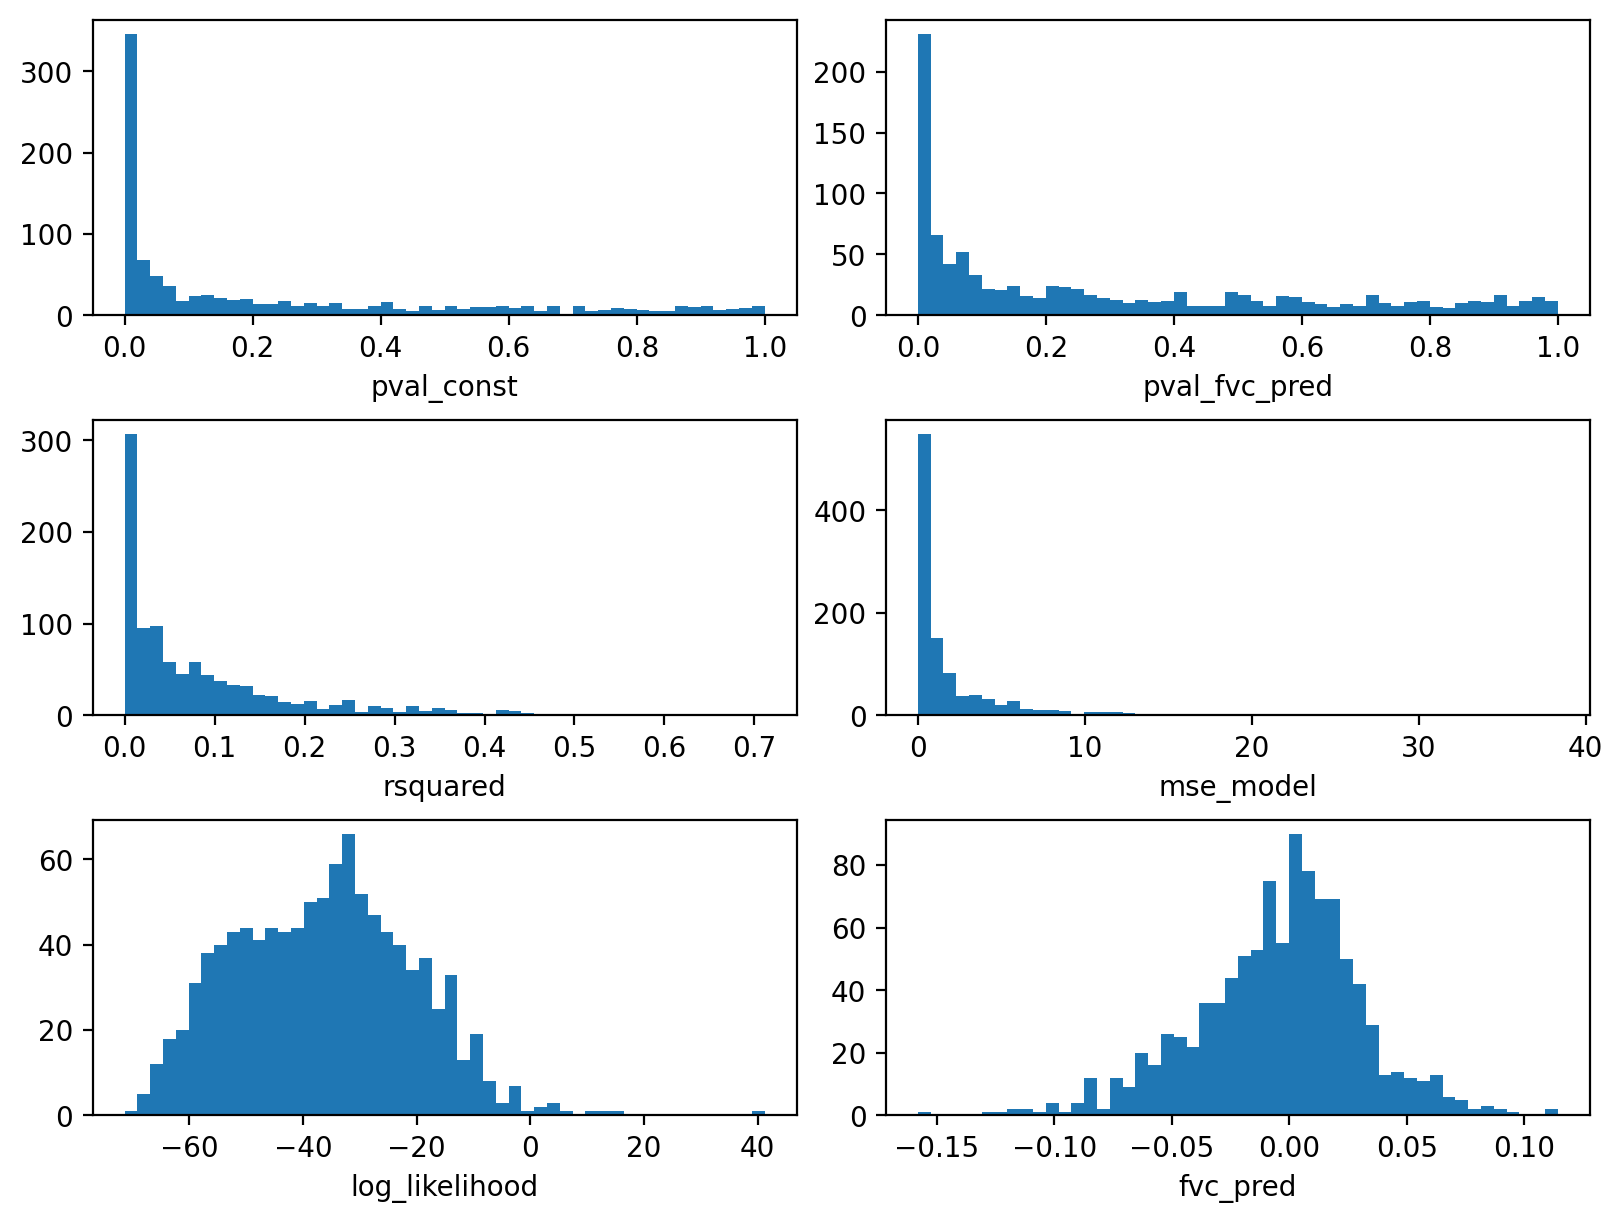

In [31]:
fig, axes = plt.subplots(figsize=(8, 6), ncols=2, nrows=3, constrained_layout=True)
for i, col in enumerate(
    ('pval_const', 'pval_fvc_pred', 'rsquared', 'mse_model', 'log_likelihood', 'fvc_pred')
):
    ax = axes[i // 2, i % 2]
    ax.hist(result[col], bins=50)
    ax.set_xlabel(col)

In [32]:
result.sort_values('rsquared', ascending=False).head(20)

,gene,const,fvc_pred,pval_const,pval_fvc_pred,rsquared,mse_model,log_likelihood
962,DHDH,11.096645,-0.157989,1.758105e-12,8.416330e-12,0.711377,38.329169,-37.862545
458,WBP5,7.878169,-0.113757,1.230242e-11,3.825497e-11,0.687695,19.871411,-26.978289
678,H2AFJ,8.608481,-0.120065,7.823140e-11,5.519364e-10,0.641205,22.136299,-33.312372
357,DNPH1,8.939300,-0.119807,8.094017e-11,1.503566e-09,0.622052,22.041475,-34.873170
107,TP53I3,7.556774,-0.102846,1.655486e-09,1.715055e-08,0.571279,16.242314,-32.990943
391,SNX8,8.314385,-0.117059,7.682390e-09,3.436801e-08,0.555603,21.041775,-39.443439
459,NGFRAP1,9.310633,-0.130176,1.693956e-08,8.385206e-08,0.534675,26.021817,-45.380206
643,COMTD1,7.894469,-0.109070,1.805173e-08,1.137171e-07,0.527311,18.267711,-38.895584
175,NR1D2,-5.391653,0.069006,3.550405e-09,1.256124e-07,0.524882,7.312188,-20.778570
73,MTX1,5.666883,-0.075780,2.063269e-08,2.476975e-07,0.507983,8.818173,-25.877575


Text(0, 0.5, 'z-score$(DHDH)$')

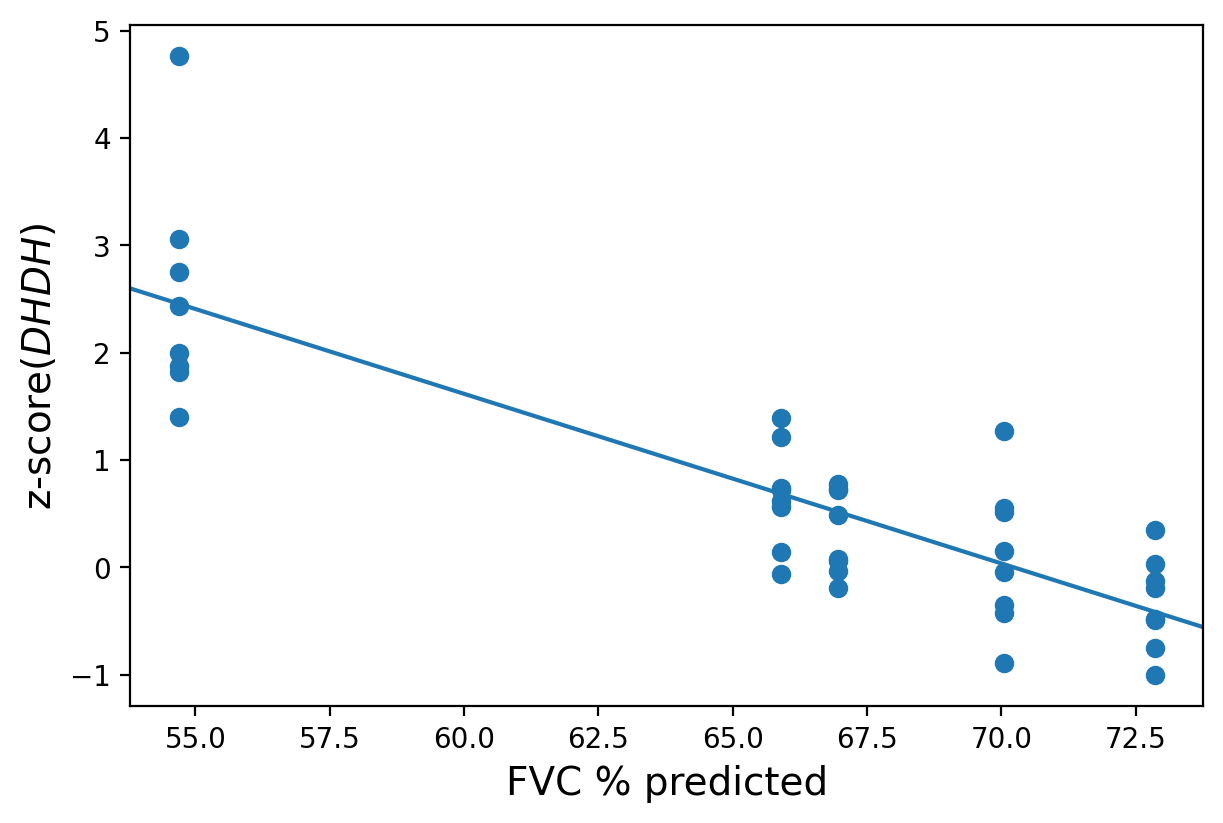

In [ ]:
GENE = 'DHDH'
idx = metadata_df.fvc_pred.notna()
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
ax.scatter(
    metadata_df.fvc_pred[idx],
    pseudobulk[GENE][idx]
)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.axline(
    [0, result.const[result.gene.eq(GENE)].values[0]],
    slope=result.fvc_pred[result.gene.eq(GENE)].values[0]
)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel('FVC % predicted', size=14)
ax.set_ylabel(f'z-score$({GENE})$', size=14)

In [34]:
result['padj_fvc_pred'] = statsmodels.stats.multitest.fdrcorrection(result.pval_fvc_pred)[1]

In [35]:
result.loc[result.padj_fvc_pred.lt(0.05)].sort_values('rsquared', ascending=False).head(20)

,gene,const,fvc_pred,pval_const,pval_fvc_pred,rsquared,mse_model,log_likelihood,padj_fvc_pred
962,DHDH,11.096645,-0.157989,1.758105e-12,8.416330e-12,0.711377,38.329169,-37.862545,8.601489e-09
458,WBP5,7.878169,-0.113757,1.230242e-11,3.825497e-11,0.687695,19.871411,-26.978289,1.954829e-08
678,H2AFJ,8.608481,-0.120065,7.823140e-11,5.519364e-10,0.641205,22.136299,-33.312372,1.880263e-07
357,DNPH1,8.939300,-0.119807,8.094017e-11,1.503566e-09,0.622052,22.041475,-34.873170,3.841611e-07
107,TP53I3,7.556774,-0.102846,1.655486e-09,1.715055e-08,0.571279,16.242314,-32.990943,3.505573e-06
391,SNX8,8.314385,-0.117059,7.682390e-09,3.436801e-08,0.555603,21.041775,-39.443439,5.854018e-06
459,NGFRAP1,9.310633,-0.130176,1.693956e-08,8.385206e-08,0.534675,26.021817,-45.380206,1.224240e-05
643,COMTD1,7.894469,-0.109070,1.805173e-08,1.137171e-07,0.527311,18.267711,-38.895584,1.426399e-05
175,NR1D2,-5.391653,0.069006,3.550405e-09,1.256124e-07,0.524882,7.312188,-20.778570,1.426399e-05
73,MTX1,5.666883,-0.075780,2.063269e-08,2.476975e-07,0.507983,8.818173,-25.877575,2.531469e-05


In [36]:
result.sort_values('rsquared', ascending=False).to_csv('08a_degs_linear_models.csv')

# 2. Linear models on genes

In [37]:
metadata_df = ds_processed.obs.loc[
    ds_processed.obs.cell_type.isin(deg_cell_types)
][
    ['External Sample ID', 'cell_type', 'Status']
].drop_duplicates(subset=['External Sample ID', 'cell_type'])

In [38]:
pseudobulk = np.zeros((metadata_df.shape[0], ds_processed.raw.var_names.size))
for i, (_, metadata_row) in enumerate(metadata_df.iterrows()):
    metadata_idx = (
        ds_processed.obs.cell_type.eq(metadata_row.cell_type)
        & ds_processed.obs['External Sample ID'].eq(metadata_row['External Sample ID'])
    )
    pseudobulk[i, :] = ds_processed.raw.X[metadata_idx].mean(axis=0)

In [39]:
pseudobulk.shape

(184, 25538)

In [40]:
pseudobulk = pd.DataFrame(pseudobulk, index=metadata_df.index, columns=ds_processed.raw.var_names)

Take genes that are detected in 80% of pseudobulks in SSc

In [41]:
sample_idx = metadata_df.Status.eq('SSc')

In [42]:
gene_idx = (pseudobulk.loc[sample_idx, :].gt(0).sum(axis=0) / sample_idx.sum()).ge(0.8)

In [43]:
pseudobulk = pseudobulk.loc[:, gene_idx].copy()

In [44]:
gene_idx.sum()

12475

In [45]:
pseudobulk = ((pseudobulk - pseudobulk.mean(axis=0)) / pseudobulk.std(axis=0))

In [46]:
idx = metadata_df['External Sample ID'].isin(sample_to_fvc.index)
metadata_df.loc[idx, 'fvc_pred'] = sample_to_fvc[metadata_df['External Sample ID'][idx]].values
metadata_df.loc[idx, 'fev1_pred'] = sample_to_fev1[metadata_df['External Sample ID'][idx]].values

In [ ]:
result = []
for gene in pseudobulk.columns:
    idx = metadata_df.fvc_pred.notna()
    y = pseudobulk[gene][idx]
    x = metadata_df.fvc_pred[idx]
    x = statsmodels.api.add_constant(x)
    model = statsmodels.api.OLS(y, x)
    fit = model.fit()
    result.append((
        gene,
        fit.params.const,
        fit.params.fvc_pred,
        fit.pvalues.const,
        fit.pvalues.fvc_pred,
        fit.rsquared,
        fit.mse_model,
        fit.llf
    ))
result = pd.DataFrame(
    result,
    columns=['gene', 'const', 'fvc_pred', 'pval_const', 'pval_fvc_pred',
             'rsquared', 'mse_model', 'log_likelihood']
)

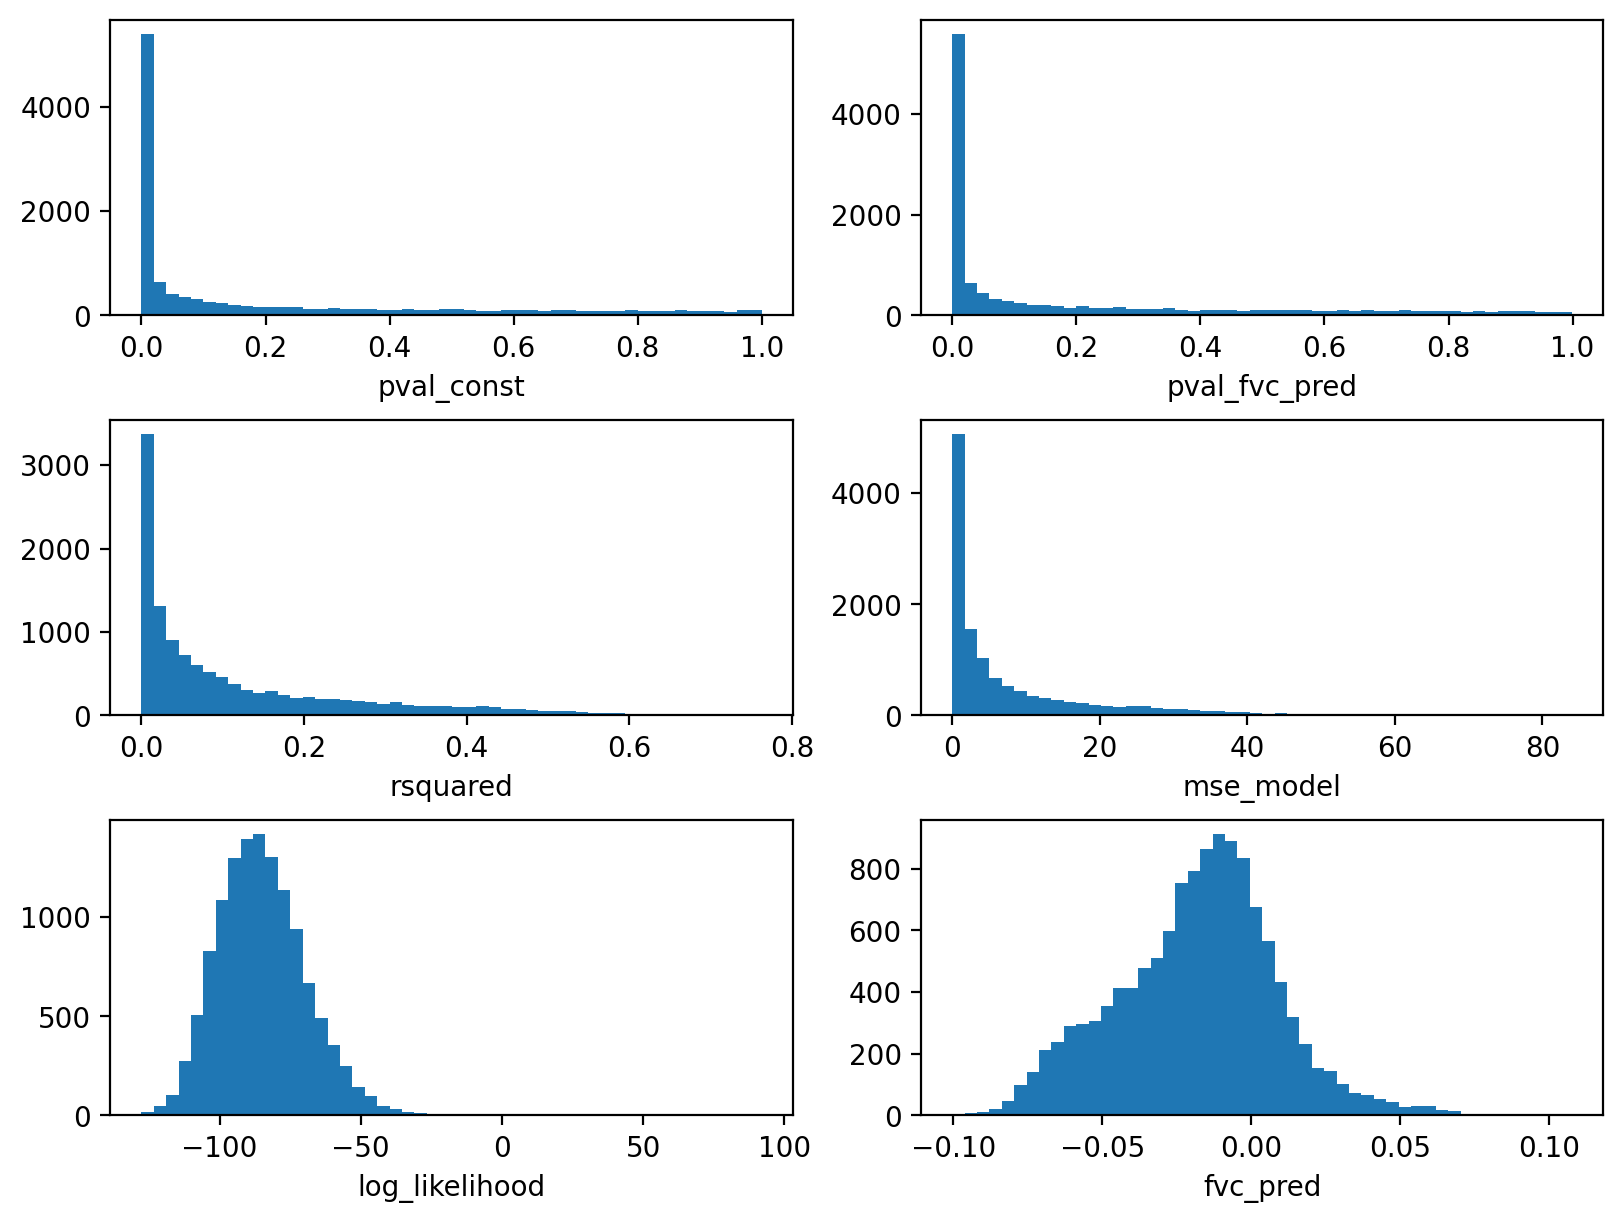

In [48]:
fig, axes = plt.subplots(figsize=(8, 6), ncols=2, nrows=3, constrained_layout=True)
for i, col in enumerate(
    ('pval_const', 'pval_fvc_pred', 'rsquared', 'mse_model', 'log_likelihood', 'fvc_pred')
):
    ax = axes[i // 2, i % 2]
    ax.hist(result[col], bins=50)
    ax.set_xlabel(col)

In [49]:
result.sort_values('rsquared', ascending=False).head(20)

,gene,const,fvc_pred,pval_const,pval_fvc_pred,rsquared,mse_model,log_likelihood
5486,DPYSL2,-7.264529,0.107900,6.409479e-23,1.474976e-23,0.762722,84.049914,-65.698501
9458,TUFM,7.081594,-0.096232,2.977548e-24,7.978455e-23,0.751051,66.854975,-59.742488
10276,CDK5RAP3,6.709474,-0.095242,1.754203e-22,4.423251e-22,0.738625,65.486685,-61.351991
11289,QTRT1,6.630336,-0.094056,3.345235e-22,8.678686e-22,0.733568,63.866052,-61.387036
10181,NT5C3B,6.201225,-0.091798,6.517595e-21,1.902040e-21,0.727559,60.835503,-60.736040
11095,WDR18,5.998747,-0.080834,1.583669e-22,5.774525e-21,0.718823,47.171979,-53.149765
11433,IFI30,5.772575,-0.081385,1.538344e-20,5.210421e-20,0.700688,47.816958,-56.808514
12317,TYMP,5.594936,-0.076519,4.725984e-21,7.341768e-20,0.697759,42.269944,-52.871045
4432,SNX8,6.734908,-0.092164,5.095444e-21,7.671665e-20,0.697381,61.322193,-66.329831
5776,GSDMD,5.443860,-0.078317,7.955024e-20,9.843449e-20,0.695231,44.280046,-54.973983


In [50]:
result['padj_fvc_pred'] = statsmodels.stats.multitest.fdrcorrection(result.pval_fvc_pred)[1]

In [51]:
result.loc[result.padj_fvc_pred.lt(0.05)].sort_values('rsquared', ascending=False).head(20)

,gene,const,fvc_pred,pval_const,pval_fvc_pred,rsquared,mse_model,log_likelihood,padj_fvc_pred
5486,DPYSL2,-7.264529,0.107900,6.409479e-23,1.474976e-23,0.762722,84.049914,-65.698501,1.840032e-19
9458,TUFM,7.081594,-0.096232,2.977548e-24,7.978455e-23,0.751051,66.854975,-59.742488,4.976561e-19
10276,CDK5RAP3,6.709474,-0.095242,1.754203e-22,4.423251e-22,0.738625,65.486685,-61.351991,1.839335e-18
11289,QTRT1,6.630336,-0.094056,3.345235e-22,8.678686e-22,0.733568,63.866052,-61.387036,2.706665e-18
10181,NT5C3B,6.201225,-0.091798,6.517595e-21,1.902040e-21,0.727559,60.835503,-60.736040,4.745589e-18
11095,WDR18,5.998747,-0.080834,1.583669e-22,5.774525e-21,0.718823,47.171979,-53.149765,1.200620e-17
11433,IFI30,5.772575,-0.081385,1.538344e-20,5.210421e-20,0.700688,47.816958,-56.808514,9.285715e-17
12317,TYMP,5.594936,-0.076519,4.725984e-21,7.341768e-20,0.697759,42.269944,-52.871045,1.063378e-16
4432,SNX8,6.734908,-0.092164,5.095444e-21,7.671665e-20,0.697381,61.322193,-66.329831,1.063378e-16
5776,GSDMD,5.443860,-0.078317,7.955024e-20,9.843449e-20,0.695231,44.280046,-54.973983,1.227970e-16


Text(0, 0.5, 'z-score$(IFI30)$')

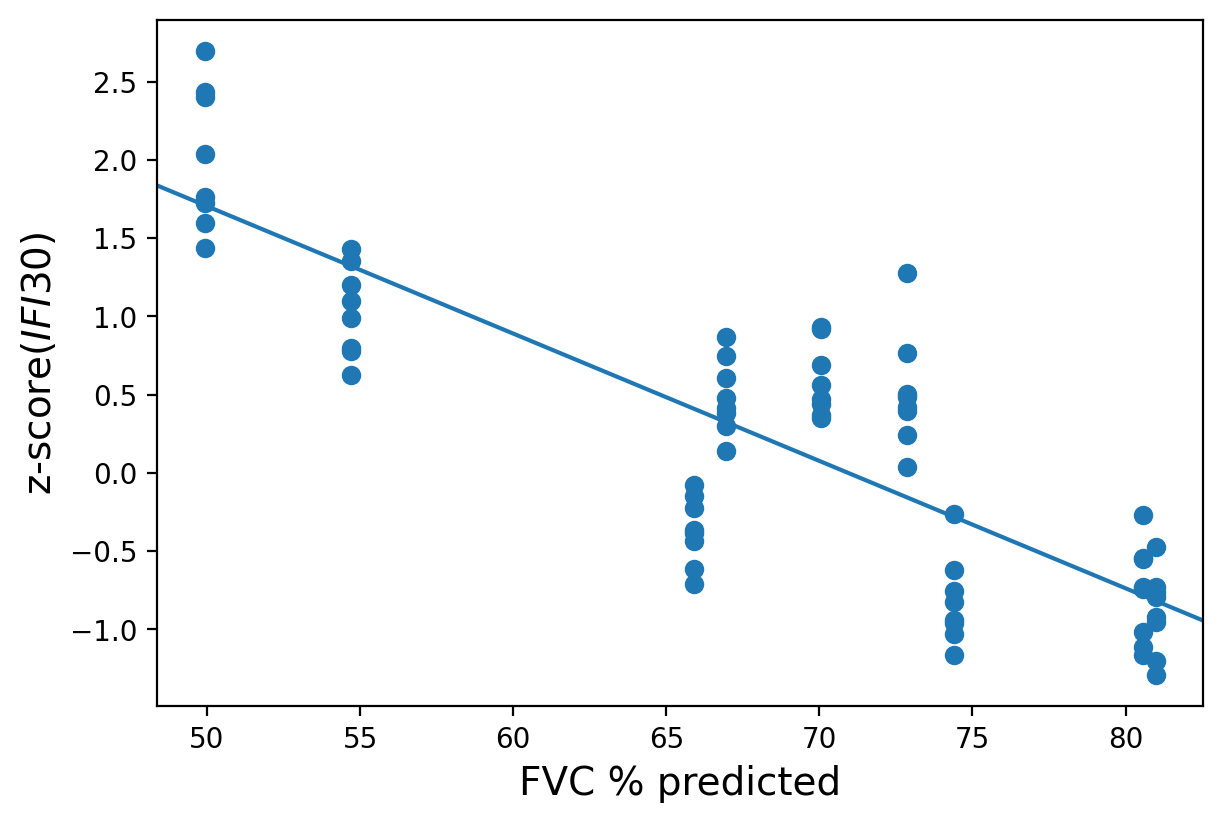

In [ ]:
GENE = 'IFI30'
idx = metadata_df.fvc_pred.notna()
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
ax.scatter(
    metadata_df.fvc_pred[idx],
    pseudobulk[GENE][idx]
)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.axline(
    [0, result.const[result.gene.eq(GENE)].values[0]],
    slope=result.fvc_pred[result.gene.eq(GENE)].values[0]
)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel('FVC % predicted', size=14)
ax.set_ylabel(f'z-score$({GENE})$', size=14)

In [53]:
result.sort_values('rsquared', ascending=False).to_csv('08b_genes_linear_models.csv')